# Fake News Analysis and Classification (Google Colab edition - TSV Dataset)

This notebook performs exploratory data analysis (EDA) on the LIAR fake news dataset and evaluates different classification models.
This notebook is designed to run on Google Colab to leverage GPU acceleration for training our fake news detection models, particularly the DistilBERT transformer model which benefits significantly from GPU processing.

In [1]:
# Clone the repository
!git clone https://github.com/smaoui-me/fake-news-predictor.git

Cloning into 'fake-news-predictor'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 51 (delta 18), reused 48 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 1.50 MiB | 3.97 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sys.path.append('/content/fake-news-predictor')  # Path to the repo root

from models import load_data, LogisticModel, DistilBertModel

# Check if GPU is available
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

GPU available: True
GPU device: Tesla T4


## 1. Load and Explore the Dataset

In [4]:
# Load the dataset from TSV files
data = load_data('/content/fake-news-predictor/data', use_predefined_splits=True)
df = data['full_data']

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Original label distribution:{df['label'].value_counts()}")
print(f"Original label distribution (percentage):{df['label'].value_counts(normalize=True) * 100}")

print(f"Binary label distribution:{df['binary_label'].value_counts()}")
print(f"Binary label distribution (percentage):{df['binary_label'].value_counts(normalize=True) * 100}")

# Display split sizes
print(f"Train set size: {len(data['train']['df'])}")
print(f"Test set size: {len(data['test']['df'])}")
print(f"Validation set size: {len(data['valid']['df'])}")

Dataset shape: (12791, 15)
Original label distribution:label
half-true      2627
false          2507
mostly-true    2454
barely-true    2103
true           2053
pants-fire     1047
Name: count, dtype: int64
Original label distribution (percentage):label
half-true      20.537878
false          19.599719
mostly-true    19.185365
barely-true    16.441248
true           16.050348
pants-fire      8.185443
Name: proportion, dtype: float64
Binary label distribution:binary_label
1    8284
0    4507
Name: count, dtype: int64
Binary label distribution (percentage):binary_label
1    64.764287
0    35.235713
Name: proportion, dtype: float64
Train set size: 10240
Test set size: 1267
Validation set size: 1284


In [5]:
# Display sample data
df.head()

,id,label,statement,subject,speaker,job_title,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,binary_label
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,1
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,1
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,1


## 2. Exploratory Data Analysis

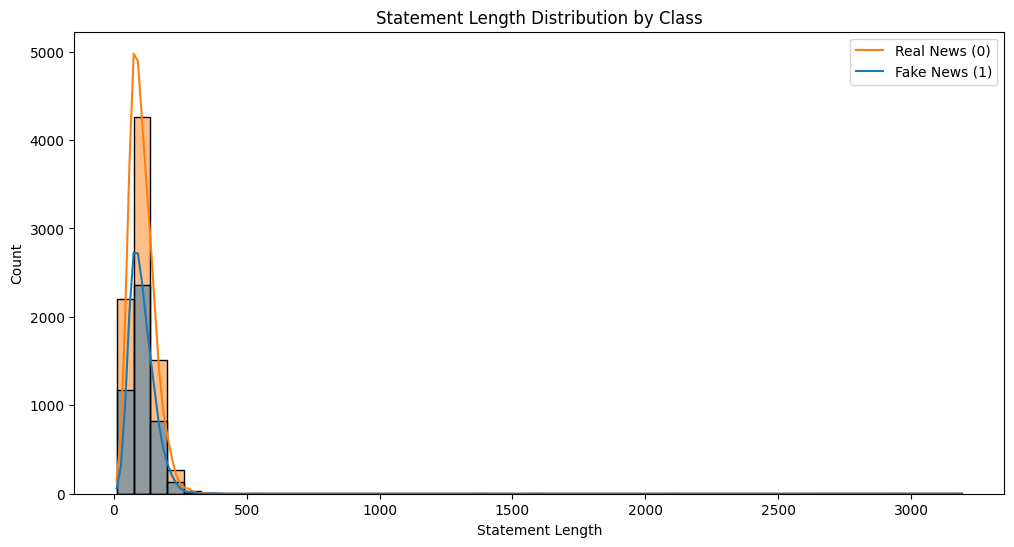

In [6]:
# Text length distribution
df['statement_length'] = df['statement'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='statement_length', hue='binary_label', bins=50, kde=True)
plt.title('Statement Length Distribution by Class')
plt.xlabel('Statement Length')
plt.ylabel('Count')
plt.legend(['Real News (0)', 'Fake News (1)'])
plt.show()

In [7]:
# 1. Check for missing or null values
print("Checking for missing values:")
missing_values = df.isnull().sum()
print(missing_values)

# 2. Check label distribution
print("Original label distribution:")
print(df['label'].value_counts())
print("Unique labels:", df['label'].unique())

print("Binary label distribution:")
print(df['binary_label'].value_counts())

# 3. Check for duplicates
duplicate_count = df.duplicated(['statement', 'binary_label']).sum()
print(f"Number of duplicate entries (same statement and label): {duplicate_count}")

# Clean the data
# Remove missing values if any
df = df.dropna(subset=['statement', 'binary_label'])

# Remove duplicates if any
df = df.drop_duplicates(subset=['statement', 'binary_label'])

# Show cleaned data stats
print("After cleaning:")
print(f"Total samples: {len(df)}")
print("Binary label distribution after cleaning:")
print(df['binary_label'].value_counts())

# Update the data dictionary with cleaned data
data['full_data'] = df

Checking for missing values:
id                         0
label                      0
statement                  0
subject                    2
speaker                    2
job_title               3568
state                   2751
party                      2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  131
binary_label               0
statement_length           0
dtype: int64
Original label distribution:
label
half-true      2627
false          2507
mostly-true    2454
barely-true    2103
true           2053
pants-fire     1047
Name: count, dtype: int64
Unique labels: ['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']
Binary label distribution:
binary_label
1    8284
0    4507
Name: count, dtype: int64
Number of duplicate entries (same statement and label): 23
After cleaning:
Total samples: 12768
Binary label distribution after cleaning:
bina

## 3. Train and Evaluate Logistic Regression Model

Logistic Regression Model Metrics on Test Set:
Accuracy: 0.6440
Precision: 0.6710
Recall: 0.8802
F1_score: 0.7615


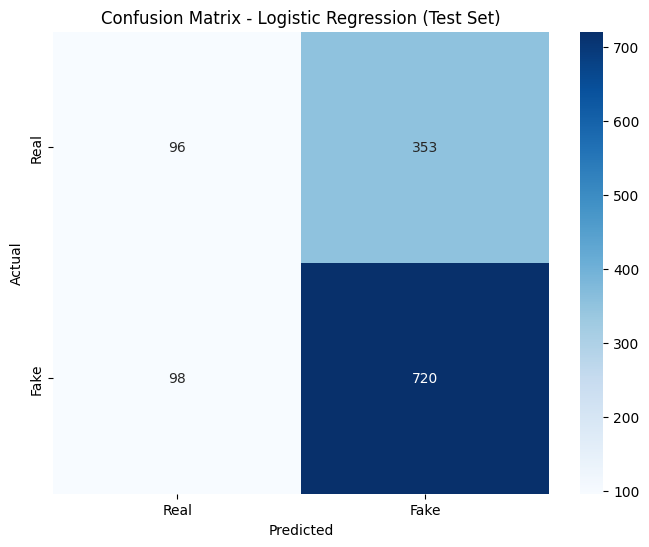

Logistic Regression Model Metrics on Validation Set:
Accuracy: 0.6760
Precision: 0.7063
Recall: 0.8877
F1_score: 0.7867


In [8]:
# Initialize and train the Logistic Regression model
logistic_model = LogisticModel(max_features=10000, preprocess=True)
logistic_model.train(data['train']['texts'], data['train']['labels'])

# Evaluate the model on test set
logistic_metrics = logistic_model.evaluate(data['test']['texts'], data['test']['labels'])

# Display metrics
print("Logistic Regression Model Metrics on Test Set:")
for metric, value in logistic_metrics.items():
    if metric != 'confusion_matrix':
        print(f"{metric.capitalize()}: {value:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    logistic_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Real', 'Fake'],
    yticklabels=['Real', 'Fake']
)
plt.title('Confusion Matrix - Logistic Regression (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Evaluate on validation set
logistic_val_metrics = logistic_model.evaluate(data['valid']['texts'], data['valid']['labels'])

# Display validation metrics
print("Logistic Regression Model Metrics on Validation Set:")
for metric, value in logistic_val_metrics.items():
    if metric != 'confusion_matrix':
        print(f"{metric.capitalize()}: {value:.4f}")

# Save the model
os.makedirs('/content/models', exist_ok=True)
logistic_model.save('/content/models/logistic_model.pkl')

## 4. Train and Evaluate DistilBERT Model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 - Average Loss: 0.6255
Epoch 2/2 - Average Loss: 0.5719
DistilBERT Model Metrics on Test Set:
Accuracy: 0.6803
Precision: 0.7277
Recall: 0.8068
F1_score: 0.7652


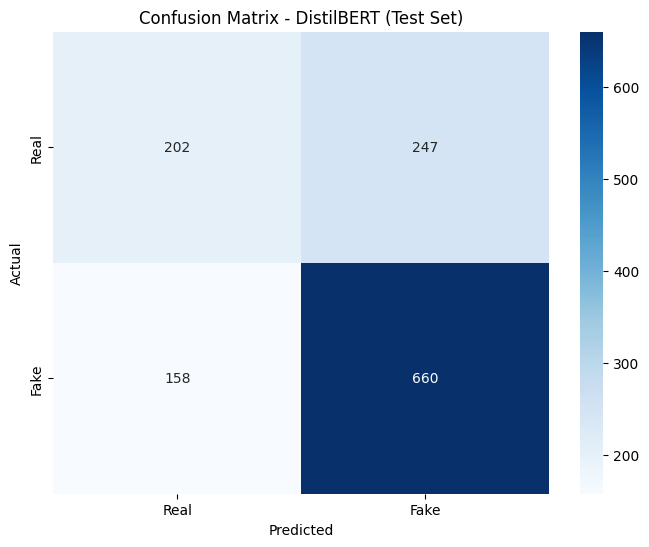

DistilBERT Model Metrics on Validation Set:
Accuracy: 0.6791
Precision: 0.7374
Recall: 0.8125
F1_score: 0.7731


In [9]:
# Initialize and train the DistilBERT model
# Note: This may take some time to run
distilbert_model = DistilBertModel(max_length=128, batch_size=16, epochs=2)
distilbert_model.train(data['train']['texts'], data['train']['labels'])

# Evaluate the model on test set
distilbert_metrics = distilbert_model.evaluate(data['test']['texts'], data['test']['labels'])

# Display metrics
print("DistilBERT Model Metrics on Test Set:")
for metric, value in distilbert_metrics.items():
    if metric != 'confusion_matrix':
        print(f"{metric.capitalize()}: {value:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    distilbert_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Real', 'Fake'],
    yticklabels=['Real', 'Fake']
)
plt.title('Confusion Matrix - DistilBERT (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Evaluate on validation set
distilbert_val_metrics = distilbert_model.evaluate(data['valid']['texts'], data['valid']['labels'])

# Display validation metrics
print("DistilBERT Model Metrics on Validation Set:")
for metric, value in distilbert_val_metrics.items():
    if metric != 'confusion_matrix':
        print(f"{metric.capitalize()}: {value:.4f}")

# Save the model
distilbert_model.save('/content/models/distilbert_model')

## 5. Compare Model Performance

In [10]:
# Compare model performance on test set
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
models = ['Logistic Regression', 'DistilBERT']
test_performance = {
    'Logistic Regression': [logistic_metrics[metric] for metric in metrics],
    'DistilBERT': [distilbert_metrics[metric] for metric in metrics]
}

# Create a DataFrame for test set comparison
test_performance_df = pd.DataFrame(test_performance, index=metrics)
test_performance_df.index = [metric.capitalize() for metric in metrics]

# Display the test set comparison
print("Model Performance Comparison on Test Set:")
test_performance_df

Model Performance Comparison on Test Set:


,Logistic Regression,DistilBERT
Accuracy,0.644041,0.680347
Precision,0.671016,0.727674
Recall,0.880196,0.806846
F1_score,0.761502,0.765217


In [11]:
# Compare model performance on validation set
val_performance = {
    'Logistic Regression': [logistic_val_metrics[metric] for metric in metrics],
    'DistilBERT': [distilbert_val_metrics[metric] for metric in metrics]
}

# Create a DataFrame for validation set comparison
val_performance_df = pd.DataFrame(val_performance, index=metrics)
val_performance_df.index = [metric.capitalize() for metric in metrics]

# Display the validation set comparison
print("Model Performance Comparison on Validation Set:")
val_performance_df

Model Performance Comparison on Validation Set:


,Logistic Regression,DistilBERT
Accuracy,0.676012,0.679128
Precision,0.706262,0.737395
Recall,0.887731,0.812500
F1_score,0.786667,0.773128


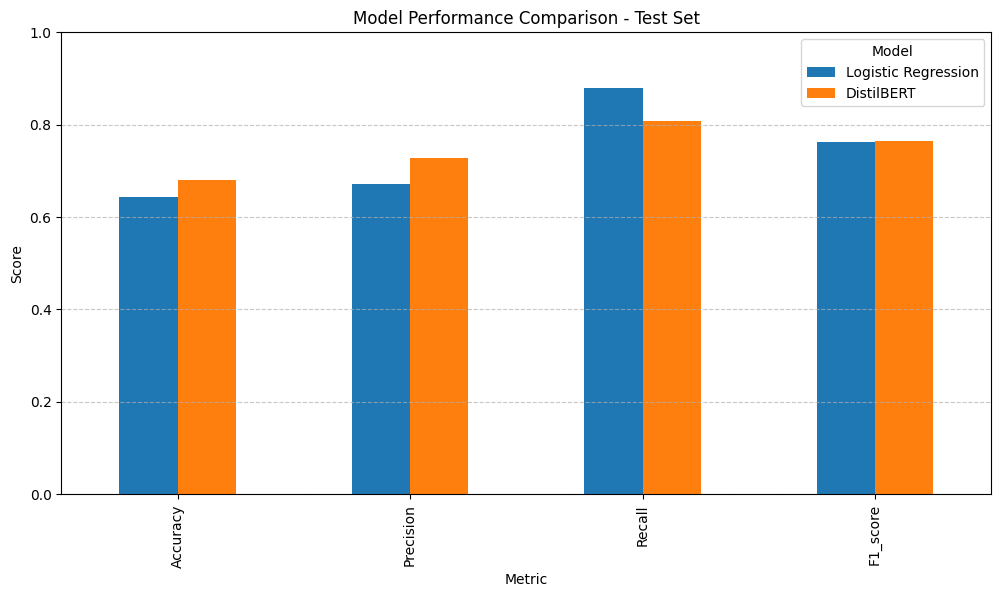

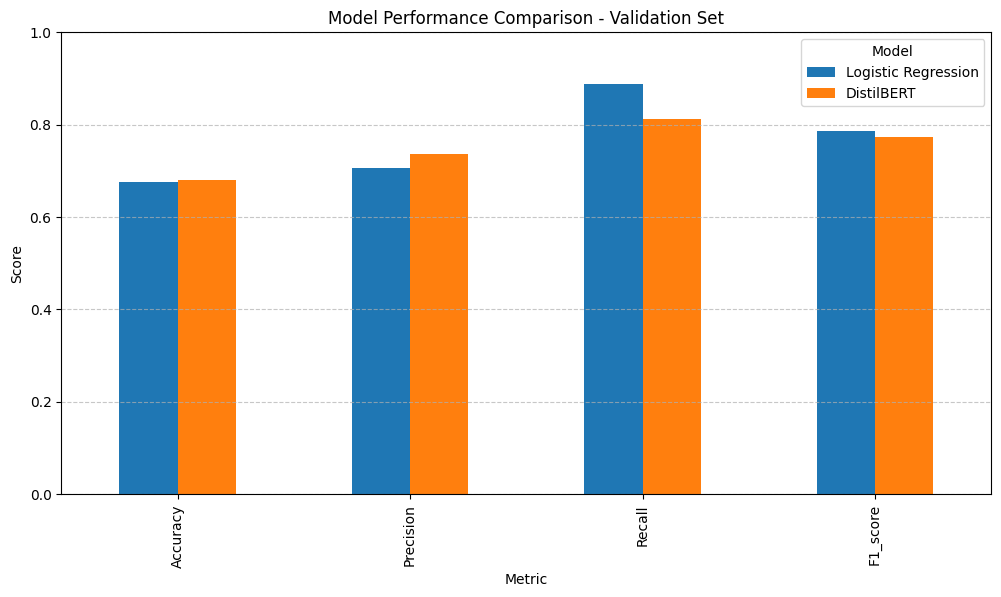

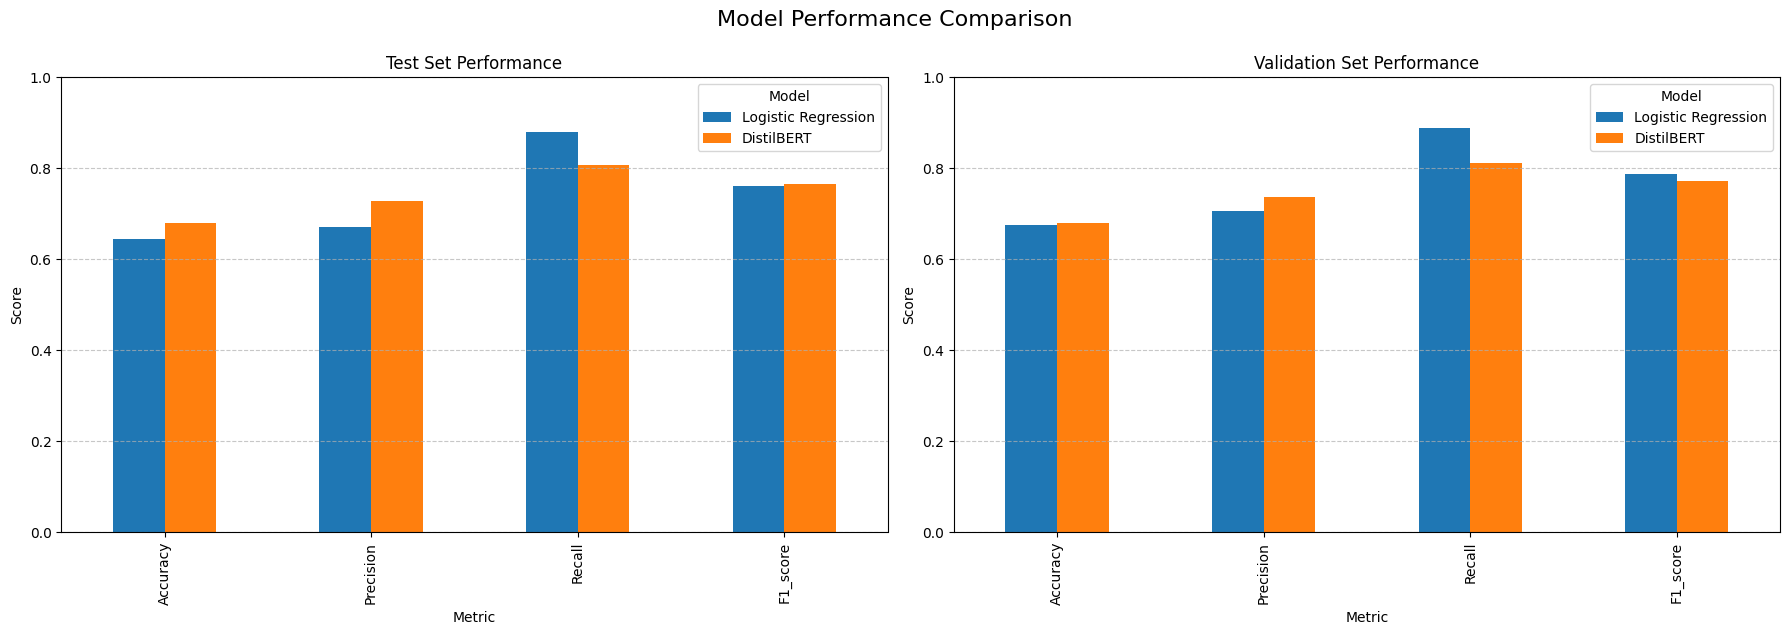

In [12]:
# Plot the test set comparison
plt.figure(figsize=(12, 6))
test_performance_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison - Test Set')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot the validation set comparison
plt.figure(figsize=(12, 6))
val_performance_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison - Validation Set')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Combined plot for both test and validation
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

test_performance_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Test Set Performance')
axes[0].set_xlabel('Metric')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].legend(title='Model')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

val_performance_df.plot(kind='bar', ax=axes[1])
axes[1].set_title('Validation Set Performance')
axes[1].set_xlabel('Metric')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)
axes[1].legend(title='Model')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('Model Performance Comparison', fontsize=16, y=1.05)
plt.show()

## 6. Example Predictions

In [13]:
# Get some examples from the test set
examples = data['test']['texts'].iloc[:5].tolist()
true_labels = data['test']['labels'].iloc[:5].tolist()

# Get additional metadata for context
test_df = data['test']['df'].iloc[:5]
speakers = test_df['speaker'].tolist()
contexts = test_df['context'].tolist()
original_labels = test_df['label'].tolist()

# Make predictions with both models
logistic_preds = logistic_model.predict(examples)
distilbert_preds = distilbert_model.predict(examples)

# Map binary labels to text for better readability
label_text_map = {0: 'Real', 1: 'Fake'}
true_labels_text = [label_text_map[label] for label in true_labels]
logistic_preds_text = [label_text_map[pred] for pred in logistic_preds]
distilbert_preds_text = [label_text_map[pred] for pred in distilbert_preds]

# Display the results
results = pd.DataFrame({
    'Statement': [text[:100] + '...' for text in examples],
    'Speaker': speakers,
    'Context': contexts,
    'Original Label': original_labels,
    'Binary Label': true_labels_text,
    'Logistic Prediction': logistic_preds_text,
    'DistilBERT Prediction': distilbert_preds_text
})

results

,Statement,Speaker,Context,Original Label,Binary Label,Logistic Prediction,DistilBERT Prediction
0,Building a wall on the U.S.-Mexico border will...,rick-perry,Radio interview,true,Real,Fake,Fake
1,Wisconsin is on pace to double the number of l...,katrina-shankland,a news conference,false,Fake,Fake,Fake
2,Says John McCain has done nothing to help the ...,donald-trump,comments on ABC's This Week.,false,Fake,Fake,Fake
3,Suzanne Bonamici supports a plan that will cut...,rob-cornilles,a radio show,half-true,Fake,Fake,Fake
4,When asked by a reporter whether hes at the ce...,state-democratic-party-wisconsin,a web video,pants-fire,Fake,Fake,Fake


## 7. Download Trained Models

In [ ]:
# Download the trained models
from google.colab import files

# Compress the models directory
!zip -r /content/models.zip /content/models

# Download the compressed file
files.download('/content/models.zip')